In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/housesalesprediction/kc_house_data.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler


In [3]:
train=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

train.shape


(1460, 81)

In [4]:
train.columns
train.head()
train.describe()






Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [5]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')


Total Features:  43 categorical + 38 numerical = 81 features


In [6]:
train.select_dtypes(include=['int64','float64']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

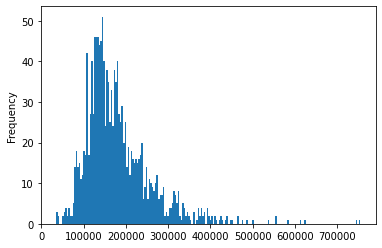

In [7]:
train.SalePrice.plot.hist(bins=200)

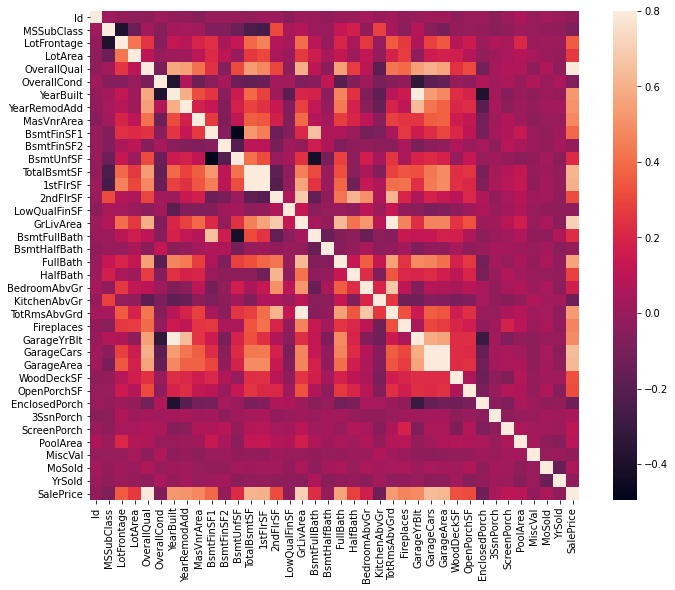

In [8]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [9]:
price_corr= train.corr()["SalePrice"]
price_corr[price_corr.abs()>0.4]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.477493
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.486362
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [10]:
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

Most Correlated Features
0                SalePrice
1              OverallQual
2                GrLivArea
3               GarageCars
4               GarageArea
5              TotalBsmtSF
6                 1stFlrSF
7                 FullBath
8             TotRmsAbvGrd
9                YearBuilt

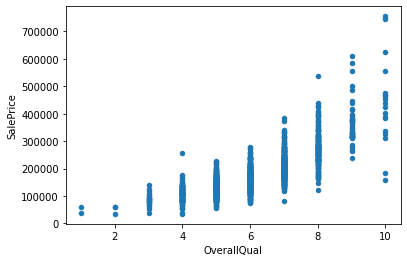

In [11]:
train.plot.scatter(x="OverallQual", y="SalePrice")

In [12]:
import seaborn as sns


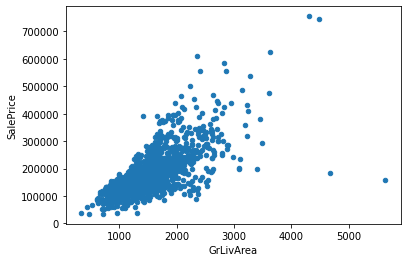

In [13]:
train.plot.scatter(x="GrLivArea", y="SalePrice")

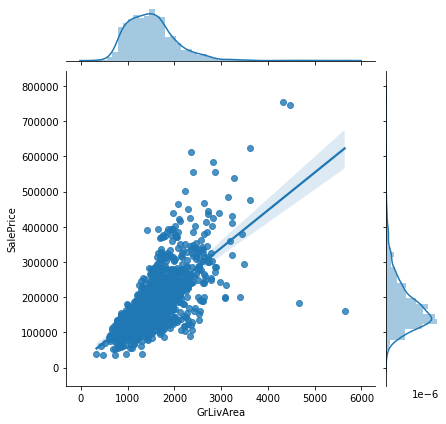

In [14]:
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')


In [15]:
train = train.drop(train[(train['GrLivArea']>4000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)


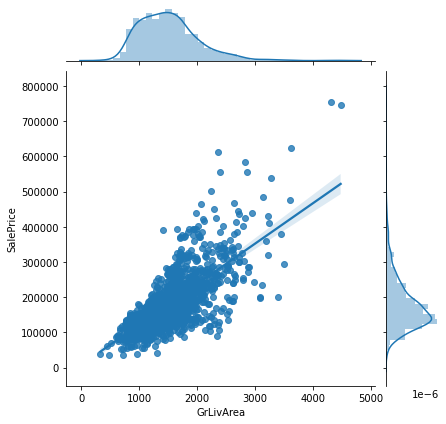

In [16]:
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

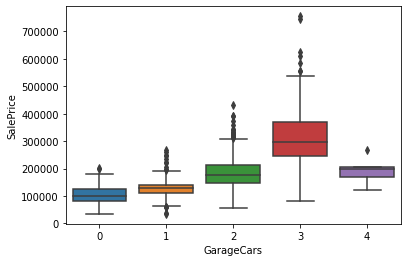

In [17]:
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

In [18]:
train = train.drop(train[(train['GarageCars']>3) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

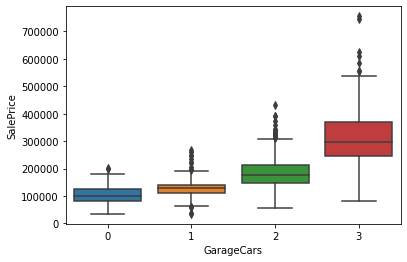

In [19]:
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

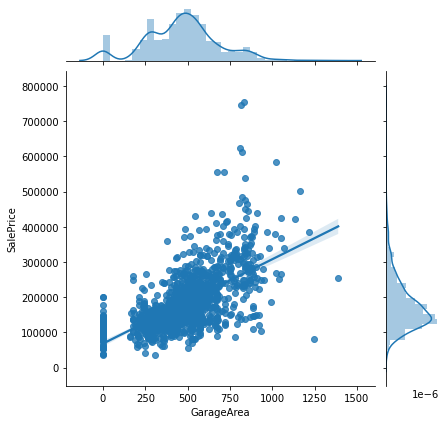

In [20]:
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

In [21]:
train = train.drop(train[(train['GarageArea']>1000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

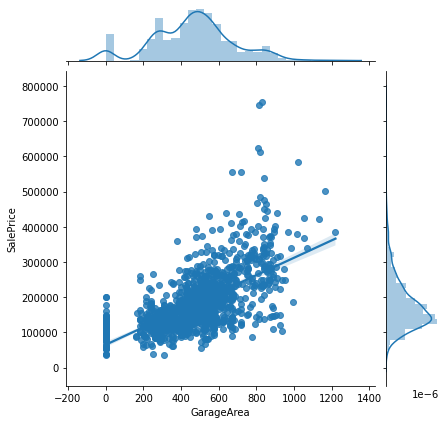

In [22]:
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

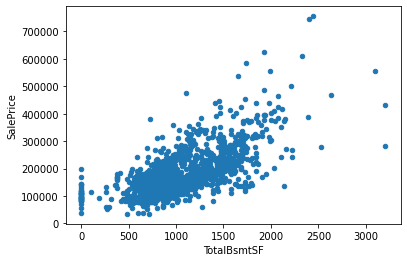

In [23]:
train.plot.scatter(x="TotalBsmtSF", y="SalePrice")

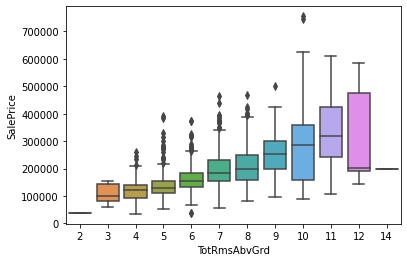

In [24]:
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])


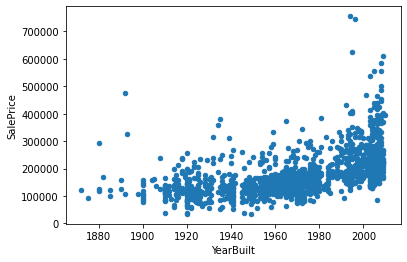

In [25]:
train.plot.scatter(x="YearBuilt", y="SalePrice")


In [26]:
training_null = pd.isnull(train).sum()
testing_null = pd.isnull(test).sum()
null = pd.concat([training_null, testing_null], axis=1, keys=["Train", "Test"])



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
null_many = null[null.sum(axis=1) > 200]  #a lot of missing values
null_few = null[(null.sum(axis=1) > 0) & (null.sum(axis=1) < 200)]  

In [28]:
null_many

Train    Test
Alley         1358  1352.0
Fence         1168  1169.0
FireplaceQu    686   730.0
LotFrontage    258   227.0
MiscFeature   1395  1408.0
PoolQC        1442  1456.0

In [29]:
null_few

Train  Test
BsmtCond         37  45.0
BsmtExposure     38  44.0
BsmtFinSF1        0   1.0
BsmtFinSF2        0   1.0
BsmtFinType1     37  42.0
BsmtFinType2     38  42.0
BsmtFullBath      0   2.0
BsmtHalfBath      0   2.0
BsmtQual         37  44.0
BsmtUnfSF         0   1.0
Electrical        1   0.0
Exterior1st       0   1.0
Exterior2nd       0   1.0
Functional        0   2.0
GarageArea        0   1.0
GarageCars        0   1.0
GarageCond       81  78.0
GarageFinish     81  78.0
GarageQual       81  78.0
GarageType       81  76.0
GarageYrBlt      81  78.0
KitchenQual       0   1.0
MSZoning          0   4.0
MasVnrArea        8  15.0
MasVnrType        8  16.0
SaleType          0   1.0
TotalBsmtSF       0   1.0
Utilities         0   2.0

In [30]:
null_has_meaning = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

In [31]:
for i in null_has_meaning:
    train[i].fillna("None", inplace=True)
    test[i].fillna("None", inplace=True)


In [32]:
null_columns=train.columns[train.isnull().any()]
train[null_columns].isnull().sum()


LotFrontage    258
MasVnrType       8
MasVnrArea       8
Electrical       1
GarageYrBlt     81
dtype: int64

In [33]:
train.drop("LotFrontage", axis=1, inplace=True)
test.drop("LotFrontage", axis=1, inplace=True)


In [34]:
from sklearn.impute import SimpleImputer

SimpleImputer = SimpleImputer(strategy="median")

In [35]:
train["GarageYrBlt"].fillna(train["GarageYrBlt"].median(), inplace=True)
test["GarageYrBlt"].fillna(test["GarageYrBlt"].median(), inplace=True)
train["MasVnrArea"].fillna(train["MasVnrArea"].median(), inplace=True)
test["MasVnrArea"].fillna(test["MasVnrArea"].median(), inplace=True)
train["MasVnrType"].fillna("None", inplace=True)
test["MasVnrType"].fillna("None", inplace=True)

In [36]:
types_train = train.dtypes #type of each feature in data: int, float, object
num_train = types_train[(types_train == int) | (types_train == float)] #numerical values are either type int or float
cat_train = types_train[types_train == object] #categorical values are type object

#we do the same for the test set
types_test = test.dtypes
num_test = types_test[(types_test == int) | (types_test == float)]
cat_test = types_test[types_test == object]

In [37]:
numerical_values_train = list(num_train.index)
numerical_values_test = list(num_test.index)


In [38]:
fill_num = []

for i in numerical_values_train:
    if i in list(null_few.index):
        fill_num.append(i)

In [39]:
for i in fill_num:
    train[i].fillna(train[i].median(), inplace=True)
    test[i].fillna(test[i].median(), inplace=True)

In [40]:
categorical_values_train = list(cat_train.index)
categorical_values_test = list(cat_test.index)

In [41]:
fill_cat = []

for i in categorical_values_train:
    if i in list(null_few.index):
        fill_cat.append(i)

In [42]:
print(fill_cat)

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'SaleType']


In [43]:
def most_common_term(lst):
    lst = list(lst)
    return max(set(lst), key=lst.count)

most_common = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'SaleType']


counter = 0
for i in fill_cat:
    most_common[counter] = most_common_term(train[i])
    counter += 1

In [44]:
most_common_dictionary = {fill_cat[0]: [most_common[0]], fill_cat[1]: [most_common[1]], fill_cat[2]: [most_common[2]], fill_cat[3]: [most_common[3]],
                          fill_cat[4]: [most_common[4]], fill_cat[5]: [most_common[5]], fill_cat[6]: [most_common[6]], fill_cat[7]: [most_common[7]],
                          fill_cat[8]: [most_common[8]]}
most_common_dictionary

{'MSZoning': ['RL'],
 'Utilities': ['AllPub'],
 'Exterior1st': ['VinylSd'],
 'Exterior2nd': ['VinylSd'],
 'MasVnrType': ['None'],
 'BsmtQual': ['TA'],
 'BsmtCond': ['TA'],
 'BsmtExposure': ['No'],
 'BsmtFinType1': ['Unf']}

In [45]:
counter = 0
for i in fill_cat:  
    train[i].fillna(most_common[counter], inplace=True)
    test[i].fillna(most_common[counter], inplace=True)
    counter += 1

In [46]:
training_null = pd.isnull(train).sum()
testing_null = pd.isnull(test).sum()

null = pd.concat([training_null, testing_null], axis=1, keys=["Training", "Testing"])
null[null.sum(axis=1) > 0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


Empty DataFrame
Columns: [Training, Testing]
Index: []

In [47]:


#Feature Engineering


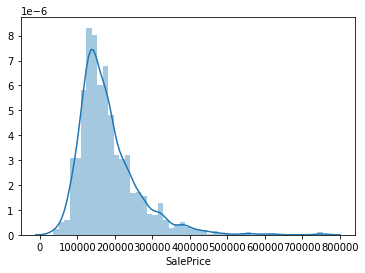

In [48]:
sns.distplot(train["SalePrice"])


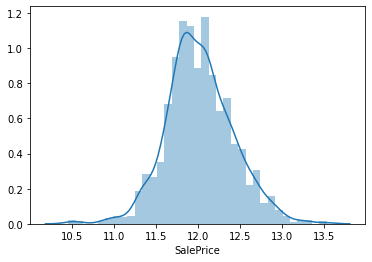

In [49]:
sns.distplot(np.log(train["SalePrice"]))

In [50]:
train["TransformedPrice"] = np.log(train["SalePrice"])

In [51]:
train.head()
train.shape

(1448, 81)

In [52]:
cat_var=train.select_dtypes(include=['object']).columns
cat_train= pd.get_dummies(train[cat_var])
cat_train.head()

MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   
3                 0            0            0            1            0   
4                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_None  Alley_Pave  ...  \
0            0            1           0           1           0  ...   
1            0            1           0           1           0  ...   
2            0            1           0           1           0  ...   
3            0            1           0           1           0  ...   
4            0            1           0           1           0  ...   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   
3                      1                      0                     0   
4                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 265 columns]

In [53]:
num_train=train[[c for c in train if c not in cat_var]]
num_train.head()

Id  MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0   1          60     8450            7            5       2003          2003   
1   2          20     9600            6            8       1976          1976   
2   3          60    11250            7            5       2001          2002   
3   4          70     9550            7            5       1915          1970   
4   5          60    14260            8            5       2000          2000   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  OpenPorchSF  EnclosedPorch  \
0       196.0         706           0  ...           61              0   
1         0.0         978           0  ...            0              0   
2       162.0         486           0  ...           42              0   
3         0.0         216           0  ...           35            272   
4       350.0         655           0  ...           84              0   

   3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SalePrice  \
0          0            0         0        0       2    2008     208500   
1          0            0         0        0       5    2007     181500   
2          0            0         0        0       9    2008     223500   
3          0            0         0        0       2    2006     140000   
4          0            0         0        0      12    2008     250000   

   TransformedPrice  
0         12.247694  
1         12.109011  
2         12.317167  
3         11.849398  
4         12.429216  

[5 rows x 38 columns]

In [54]:
joined_train=pd.concat([cat_train,num_train] ,axis=1)
joined_train.head()

MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   
3                 0            0            0            1            0   
4                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_None  Alley_Pave  ...  \
0            0            1           0           1           0  ...   
1            0            1           0           1           0  ...   
2            0            1           0           1           0  ...   
3            0            1           0           1           0  ...   
4            0            1           0           1           0  ...   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
0           61              0          0            0         0        0   
1            0              0          0            0         0        0   
2           42              0          0            0         0        0   
3           35            272          0            0         0        0   
4           84              0          0            0         0        0   

   MoSold  YrSold  SalePrice  TransformedPrice  
0       2    2008     208500         12.247694  
1       5    2007     181500         12.109011  
2       9    2008     223500         12.317167  
3       2    2006     140000         11.849398  
4      12    2008     250000         12.429216  

[5 rows x 303 columns]

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [56]:
X_training = joined_train.drop(["Id", "SalePrice", "TransformedPrice"], axis=1).values


y_training = joined_train["TransformedPrice"]



In [57]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_training, y_training, test_size=0.25, random_state=0)

In [58]:
linreg = LinearRegression()
parameters_lin = {"fit_intercept" : [True, False], "normalize" : [True, False], "copy_X" : [True, False]}
grid_linreg = GridSearchCV(linreg, parameters_lin, verbose=1 , scoring = "r2")
grid_linreg.fit(X_train, y_train)

print("Best LinReg Model: " + str(grid_linreg.best_estimator_))
print("Best Score: " + str(grid_linreg.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best LinReg Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Best Score: -1028305032371.0774


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.4s finished


In [59]:
linreg = grid_linreg.best_estimator_
linreg.fit(X_train, y_train)
lin_pred = linreg.predict(X_valid)
r2_lin = r2_score(y_valid, lin_pred)
rmse_lin = np.sqrt(mean_squared_error(y_valid, lin_pred))
print("R^2 Score: " + str(r2_lin))
print("RMSE Score: " + str(rmse_lin))

R^2 Score: 0.9197123504253446
RMSE Score: 0.11719875155884293


In [60]:
lasso = Lasso()
parameters_lasso = {"fit_intercept" : [True, False], "normalize" : [True, False], "precompute" : [True, False], "copy_X" : [True, False]}
grid_lasso = GridSearchCV(lasso, parameters_lasso, verbose=1, scoring="r2")
grid_lasso.fit(X_train, y_train)

print("Best Lasso Model: " + str(grid_lasso.best_estimator_))
print("Best Score: " + str(grid_lasso.best_score_))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Lasso Model: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=True, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Best Score: 0.7991827798750031


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.2s finished


In [61]:
lasso = grid_lasso.best_estimator_
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_valid)
r2_lasso = r2_score(y_valid, lasso_pred)
rmse_lasso = np.sqrt(mean_squared_error(y_valid, lasso_pred))
print("R^2 Score: " + str(r2_lasso))
print("RMSE Score: " + str(rmse_lasso))


R^2 Score: 0.8597294003285065
RMSE Score: 0.15491088684325963


In [62]:
ridge = Ridge()
parameters_ridge = {"fit_intercept" : [True, False], "normalize" : [True, False], "copy_X" : [True, False], "solver" : ["auto"]}
grid_ridge = GridSearchCV(ridge, parameters_ridge, verbose=1, scoring="r2")
grid_ridge.fit(X_train, y_train)

print("Best Ridge Model: " + str(grid_ridge.best_estimator_))
print("Best Score: " + str(grid_ridge.best_score_))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Ridge Model: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Best Score: 0.8989696649094391


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


In [63]:
ridge = grid_ridge.best_estimator_
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_valid)
r2_ridge = r2_score(y_valid, ridge_pred)
rmse_ridge = np.sqrt(mean_squared_error(y_valid, ridge_pred))
print("R^2 Score: " + str(r2_ridge))
print("RMSE Score: " + str(rmse_ridge))

R^2 Score: 0.9230548334504826
RMSE Score: 0.11473324724706079


In [64]:
#Decision Tree Regressor Model


In [65]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr_pred = dtr.predict(X_valid)
r2_dtr = r2_score(y_valid, dtr_pred)
rmse_dtr = np.sqrt(mean_squared_error(y_valid, dtr_pred))
print("R^2 Score: " + str(r2_dtr))
print("RMSE Score: " + str(rmse_dtr))


R^2 Score: 0.7526500395482292
RMSE Score: 0.2057095887863994


In [66]:
#Random Forest Regressor

In [67]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
r2_rf = r2_score(y_valid, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_valid, rf_pred))
print("R^2 Score: " + str(r2_rf))
print("RMSE Score: " + str(rmse_rf))

R^2 Score: 0.9021439778893625
RMSE Score: 0.1293875210243763
